## Polynomial Linear Regression

## Importing Libraries

In [1]:
import sys
import os

current_dir = os.getcwd() 
code_dir = os.path.abspath(os.path.join(current_dir, '..', '..'))

if code_dir not in sys.path:
    sys.path.append(code_dir)

from src.models.linear_models import LinearRegression
from src.loss_functions.regression_losses import MeanSquaredError, MeanAbsoluteError
from src.optimisers.gradient_based import BatchGradientDescent, StochasticGradientDescent, MiniBatchGradientDescent
from src.optimisers.cellular_automata import CellularAutomataOptimiser
from src.utils import configurations

import pandas as pd
import numpy as np
import time
import random
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression as SK_LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

## Loading the dataset

In [2]:
df = pd.read_csv("../datasets/polynomial_regression_data.csv")
X = df.drop("target", axis=1)
y = df["target"]

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=configurations.TEST_SIZE, random_state=configurations.SEED)

X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

degree = 3

poly = PolynomialFeatures(degree=degree, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

scaler = StandardScaler()
X_train_poly = scaler.fit_transform(X_train_poly)
X_test_poly = scaler.transform(X_test_poly)

In [4]:
n_features = X_train_poly.shape[1]

In [5]:
X_train = X_train_poly
X_test = X_test_poly

In [6]:
RUNS = 10

loss_functions = {
    'Mean Squared Error': MeanSquaredError(),
    'Mean Absolute Error': MeanAbsoluteError()
}
optimisers = {
    'Batch Gradient Descent': BatchGradientDescent(0.01),
    'Stochastic Gradient Descent': StochasticGradientDescent(0.01),
    'Mini Batch Gradient Descent': MiniBatchGradientDescent(0.01),
    'Cellular Automata Optimiser': CellularAutomataOptimiser(L=5, mu=0.01, omega=0.8)
}

In [7]:
final_aggregated_results = []
PLOTTING_CURVES_MSE = {}
PLOTTING_CURVES_MAE = {}
MAX_ITERS = 1000

In [8]:
print('==================== CONFIGURATIONS ====================')
print(f"MAX_ITERS={configurations.MAX_ITERS}, TEST_SIZE={configurations.TEST_SIZE}, ALPHA={configurations.ALPHA}")
print('='*56)

==================== CONFIGURATIONS ====================
MAX_ITERS=1000, TEST_SIZE=0.2, ALPHA=0.01


In [9]:
# use one optimiser at a time
for optimiser_name, optimiser in optimisers.items():
    # use one loss function at a time
    for loss_name, loss_func in loss_functions.items():
        print('='*75)
        print(f'Running Combination: {optimiser_name} / {loss_name}')

        # metric used for evaluation
        train_losses_for_avg = []
        r2_score_for_avg = []
        test_mse_for_avg = []
        test_mae_for_avg = [] 
        run_times_for_avg = []
        loss_per_iterations = []

        # test every optimiser for 10 runs
        for i in range(RUNS):
            model = LinearRegression(n_features=n_features)
            model.set_param_bounds([(-100.0, 100.0)])

            # calculating the time for each run
            start_time = time.time()
            optimiser_results = optimiser.optimise(model, loss_func, X_train, y_train, max_iters=MAX_ITERS) 
            run_time = time.time() - start_time

            model.set_params(optimiser_results['parameters'])
            y_pred = model.predict(X_test)

            test_mse = mean_squared_error(y_test, y_pred)
            test_mae = mean_absolute_error(y_test, y_pred)
            
            train_losses_for_avg.append(optimiser_results['best_loss'])
            test_mse_for_avg.append(test_mse)
            test_mae_for_avg.append(test_mae)
            r2_score_for_avg.append(r2_score(y_test, y_pred))
            run_times_for_avg.append(run_time)
            loss_per_iterations.append(optimiser_results['loss_history']) # this will store all the losses per iteration from 1 to 1000
            

        train_losses_array = np.array(train_losses_for_avg)
        test_mse_array = np.array(test_mse_for_avg)
        test_mae_array = np.array(test_mae_for_avg)
        r2_score_array = np.array(r2_score_for_avg)
        run_times_array = np.array(run_times_for_avg)
        loss_per_iterations_array = np.array(loss_per_iterations)

        avg_train_loss = np.mean(train_losses_array)
        std_dev_train_loss = np.std(train_losses_array)
        avg_test_mse = np.mean(test_mse_array)
        std_dev_test_mse = np.std(test_mse_array)
        avg_test_mae = np.mean(test_mae_array)
        std_dev_test_mae = np.std(test_mae_array)
        avg_r2_score = np.mean(r2_score_array)
        std_dev_r2_score = np.std(r2_score_array)
        avg_time = np.mean(run_times_array)
        std_dev_time = np.std(run_times_array)
        avg_loss_per_iter = np.mean(loss_per_iterations_array, axis=0)

        if loss_name == 'Mean Squared Error':
            PLOTTING_CURVES_MSE[optimiser_name] = avg_loss_per_iter
            print(f"-> Stored average MSE curve for {optimiser_name}.")
        elif loss_name == 'Mean Absolute Error':
            PLOTTING_CURVES_MAE[optimiser_name] = avg_loss_per_iter
            print(f"-> Stored average MAE curve for {optimiser_name}.")

        final_aggregated_results.append({
        'Optimiser': optimiser_name,
        'Loss_Function': loss_name,
        'Avg_Train_Loss': avg_train_loss,
        'Std_Dev_Train_Loss': std_dev_train_loss,
        'Avg_Test_MSE': avg_test_mse,
        'Std_Dev_Test_MSE': std_dev_test_mse,
        'Avg_Test_MAE': avg_test_mae,
        'Std_Dev_Test_MAE': std_dev_test_mae,
        'Avg_R2_Score': avg_r2_score,
        'Std_Dev_R2_Score': std_dev_r2_score,
        'Avg_Time_s': avg_time,
        'Std_Dev_Time_s': std_dev_time
        })

Running Combination: Batch Gradient Descent / Mean Squared Error

 Avg Loss History for Batch Gradient Descent: [2.00021774e+05 1.79789924e+05 1.62603723e+05 1.47935110e+05
 1.35352934e+05 1.24504585e+05 1.15101194e+05 1.06905694e+05
 9.97231777e+04 9.33930957e+04 8.77829385e+04 8.27831147e+04
 7.83027919e+04 7.42665147e+04 7.06114523e+04 6.72851546e+04
 6.42437211e+04 6.14503039e+04 5.88738833e+04 5.64882644e+04
 5.42712533e+04 5.22039810e+04 5.02703467e+04 4.84565592e+04
 4.67507587e+04 4.51427044e+04 4.36235155e+04 4.21854572e+04
 4.08217627e+04 3.95264853e+04 3.82943751e+04 3.71207763e+04
 3.60015416e+04 3.49329596e+04 3.39116951e+04 3.29347378e+04
 3.19993596e+04 3.11030787e+04 3.02436286e+04 2.94189320e+04
 2.86270790e+04 2.78663076e+04 2.71349879e+04 2.64316077e+04
 2.57547607e+04 2.51031361e+04 2.44755090e+04 2.38707331e+04
 2.32877333e+04 2.27254998e+04 2.21830823e+04 2.16595860e+04
 2.11541666e+04 2.06660266e+04 2.01944123e+04 1.97386103e+04
 1.92979448e+04 1.88717752e+04 1.8

In [10]:
results_df = pd.DataFrame(final_aggregated_results)

output_folder = "tables"
file_name = "PLR_results.csv"
output_path = os.path.join(output_folder, file_name)

# results_df.to_csv(output_path, index=False)
print(f"Successfully saved results to: {output_path}")

Successfully saved results to: tables\PLR_results.csv


In [11]:
results_df

,Optimiser,Loss_Function,Avg_Train_Loss,Std_Dev_Train_Loss,Avg_Test_MSE,Std_Dev_Test_MSE,Avg_Test_MAE,Std_Dev_Test_MAE,Avg_R2_Score,Std_Dev_R2_Score,Avg_Time_s,Std_Dev_Time_s
0,Batch Gradient Descent,Mean Squared Error,186.323176,87.109394,368.609727,175.777056,15.017239,3.547024,0.940345,0.028448,0.018217,0.001148
1,Batch Gradient Descent,Mean Absolute Error,324.331819,38.640898,180323.998062,69570.681172,301.887793,54.051395,-28.183402,11.259229,0.019325,0.001410
2,Stochastic Gradient Descent,Mean Squared Error,37.035335,40.046027,19.548565,8.883153,3.328676,0.756745,0.996836,0.001438,6.110317,0.836860
3,Stochastic Gradient Descent,Mean Absolute Error,1.557073,0.011519,5.742341,0.389181,1.759633,0.049440,0.999071,0.000063,5.342293,0.086296
4,Mini Batch Gradient Descent,Mean Squared Error,3.291185,0.103700,5.252399,0.089253,1.758661,0.013624,0.999150,0.000014,0.214004,0.004795
5,Mini Batch Gradient Descent,Mean Absolute Error,226.061507,38.181228,115562.754857,35105.773396,241.914717,40.344556,-17.702526,5.681473,0.214522,0.004974
6,Cellular Automata Optimiser,Mean Squared Error,51.441330,45.298290,111.683562,117.051138,7.664084,4.289779,0.981925,0.018943,37.730175,0.481810
7,Cellular Automata Optimiser,Mean Absolute Error,5.924817,2.330019,162.918142,104.622090,9.369390,3.468551,0.973634,0.016932,28.973137,5.489372


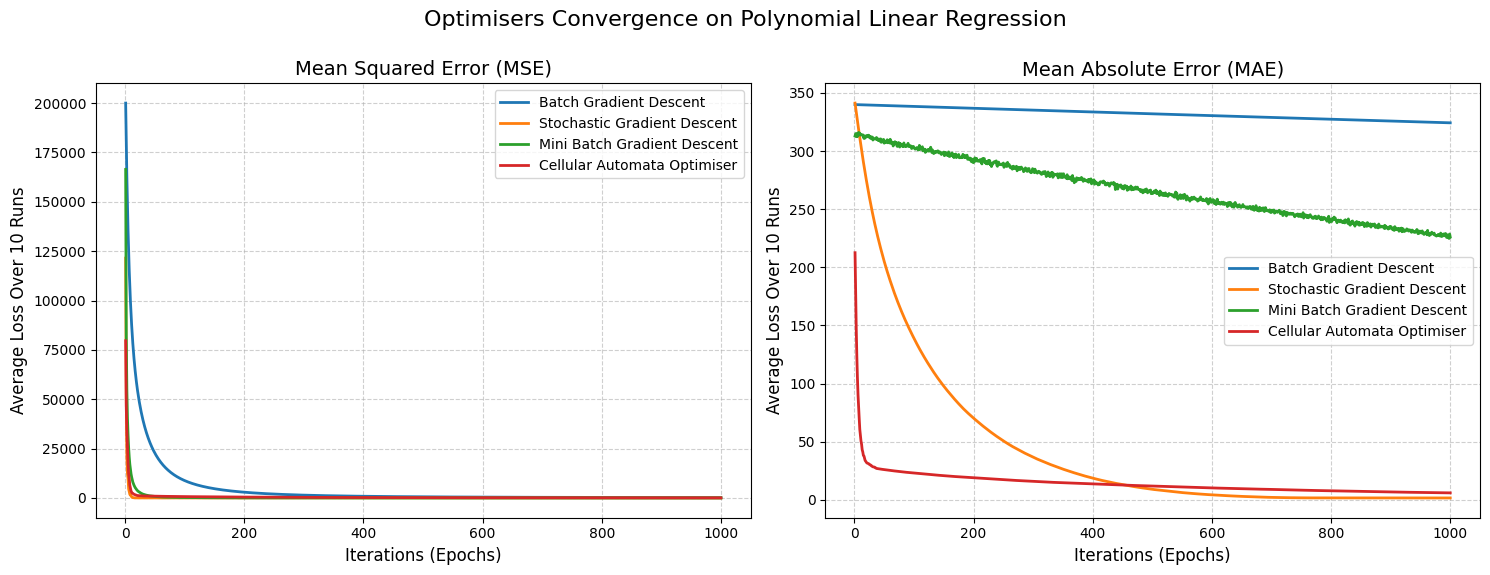

In [12]:
iterations = np.arange(1, MAX_ITERS + 1)
fig, ax = plt.subplots(1, 2, figsize=(15, 6), sharex=True)

# for Mean Squared Error
for optimiser_name, avg_curve in PLOTTING_CURVES_MSE.items():
    ax[0].plot(iterations, avg_curve, label=optimiser_name, linewidth=2)

ax[0].set_title('Mean Squared Error (MSE)', fontsize=14)
ax[0].set_xlabel('Iterations (Epochs)', fontsize=12)
ax[0].set_ylabel('Average Loss Over 10 Runs', fontsize=12)
ax[0].grid(True, linestyle='--', alpha=0.6)
ax[0].legend()

# for Mean Absolute Error
for optimiser_name, avg_curve in PLOTTING_CURVES_MAE.items():
    ax[1].plot(iterations, avg_curve, label=optimiser_name, linewidth=2)

ax[1].set_title('Mean Absolute Error (MAE)', fontsize=14)
ax[1].set_xlabel('Iterations (Epochs)', fontsize=12)
ax[1].set_ylabel(f'Average Loss Over {RUNS} Runs', fontsize=12)
ax[1].grid(True, linestyle='--', alpha=0.6)
ax[1].legend()

fig.suptitle('Optimisers Convergence on Polynomial Linear Regression', fontsize=16, y=0.95)
plt.tight_layout(rect=[0, 0, 1, 0.95])
# plt.savefig('Polynomial Linear Regression Loss Plot.png')